In [488]:
import numpy as np
from numpy import genfromtxt
%matplotlib inline
import matplotlib.pyplot as plt
import math
import skimage.io as io
import time
import copy
from operator import itemgetter
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from collections import defaultdict
from skimage.color import rgb2gray
from sklearn.datasets import load_digits
from scipy.special import digamma, gamma, gammaln
from scipy.stats import beta
from sklearn.cross_validation import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

##Подготовка данных

In [22]:
digits_dataset = load_digits()
X = digits_dataset.data
y = digits_dataset.target
X = X.astype(int)/9

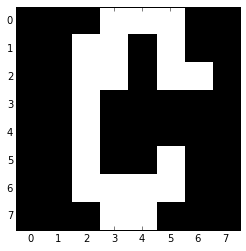

In [32]:
img = np.reshape(X[10], (8, 8))
plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest')

In [511]:
class DPMixture:
    def __init__(self, X, alpha, a, b):
        self.__a = a
        self.__b = b
        self.__alpha = alpha
        self.__X = X
        const = 10
        self.__N, self.__D = X.shape
        self.__K = int(const * alpha * math.log(1 + self.__N/alpha))
        self.__data_added = False
        self.__r_best = None
    def var_inference(self, num_start=1, display=True, max_iter=100, tol_L=1e-4):
        L_best = None
        
        good_clasters = None
        if self.__r_best != None:
            good_clasters = (self.__r_best.sum(axis=0) > 1e-4)
            at_start = copy.copy(self.__at_best)
            bt_start = copy.copy(self.__bt_best)
            
        for start in range(num_start):
            if display:
                print 'Start number:{:}'.format(start+1)
            L_prev = None
            #init random r
            self.__r = np.random.rand(self.__N, self.__K)
            self.__r /= np.sum(self.__r, axis=1)[:, np.newaxis]
            
            if (self.__data_added and good_clasters != None):
                self.__at = copy.copy(at_start)
                self.__bt = copy.copy(bt_start)
                for k in range(self.__K):
                    if good_clasters[k]:
                        continue
                    self.__at[:,k] = self.__a +  np.dot(np.transpose(self.__X), self.__r[:,k])
                    self.__bt[:,k] = self.__b +  np.dot(np.transpose(1.-self.__X), self.__r[:,k])
                    
                    self.__psi_at = digamma(self.__at)
                    self.__psi_bt = digamma(self.__bt)
                    self.__psi_abt = digamma(self.__at + self.__bt)
                    
                self.__calc_v()
                self.__calc_z()
            
            for iteraton in range(max_iter):
                self.__make_iteration()
                L = self.__calc_L()

                if display:
                    print 'Iter:{:}, L(q):{:5f}'.format(iteraton+1, L)

                if L_prev != None and L - L_prev < tol_L:
                    break
                L_prev = L
                
            if L_best == None or L_best < L_prev:
                L_best = copy.copy(L_prev)
                self.__at_best = copy.copy(self.__at)
                self.__bt_best = copy.copy(self.__bt)
                self.__r_best = copy.copy(self.__r)
                
        self.__data_added = False
    def __make_iteration(self):
         
        self.__calc_v()
        self.__calc_theta()
        self.__calc_z()
        
    def __calc_v(self):
        rk = np.sum(self.__r, axis=0)
        self.__av = 1. + rk
        self.__bv = self.__alpha + np.array([ np.sum(rk[(i+1):]) for i in range(self.__K)])
        
        self.__psi_av = digamma(self.__av)
        self.__psi_bv = digamma(self.__bv)
        self.__psi_abv = digamma(self.__av + self.__bv)
        
    def __calc_theta(self):        
        self.__at = self.__a +  np.dot(np.transpose(self.__X), self.__r)
        self.__bt = self.__b +  np.dot(np.transpose(1.-self.__X), self.__r)

        self.__psi_at = digamma(self.__at)
        self.__psi_bt = digamma(self.__bt)
        self.__psi_abt = digamma(self.__at + self.__bt)
                
    def __calc_z(self):
        self.__r = np.dot(self.__X, self.__psi_at - self.__psi_bt) + np.sum(self.__psi_bt, axis=0) - np.sum(self.__psi_abt, axis=0) \
        + self.__psi_av - self.__psi_bv + np.cumsum(self.__psi_bv - self.__psi_abv)
        self.__r -= np.max(self.__r)
        self.__r = np.exp(self.__r)
        self.__r /= np.sum(self.__r, axis=1)[:, np.newaxis]
        
    def __calc_L(self):
        p1 = np.sum((1. - self.__av)*(self.__psi_av-self.__psi_abv)+(self.__alpha - self.__bv)*(self.__psi_bv - self.__psi_abv) \
                     + gammaln(self.__av) + gammaln(self.__bv) - gammaln(self.__av + self.__bv) \
                     - gammaln(1.) - gammaln(self.__alpha) + gammaln(1. + self.__alpha))
        p2 = np.sum((self.__a - self.__at)*(self.__psi_at-self.__psi_abt)+(self.__b - self.__bt)*(self.__psi_bt - self.__psi_abt) + \
              + gammaln(self.__at) + gammaln(self.__bt) - gammaln(self.__at + self.__bt) \
                     - gammaln(self.__a) - gammaln(self.__b) + gammaln(self.__a + self.__b))
        p3 = np.sum(self.__r * (np.dot(self.__X, self.__psi_at-self.__psi_abt) + np.dot(1. - self.__X, (self.__psi_bt-self.__psi_abt)) + \
                                 self.__psi_av - self.__psi_bv + np.cumsum(self.__psi_bv - self.__psi_abv) - np.log(self.__r)))
        #print p1,p2,p3
        return p1 + p2 + p3
    def add_sample(self, X):
        if self.__X.shape[1] != X.shape[1]:
            raise 'Wrond d lenght'
            
        self.__X = np.vstack([self.__X , X])
        self.__N += X.shape[0]
        self.__data_added = True
        
    def show_clusters(self):
        t_mean = self.__at_best / (self.__at_best + self.__bt_best)
        return np.transpose(t_mean)
    def show_z(self):
        return self.__r_best

In [512]:
Step = 100
ind_start = 0
clusters = []
dpmix = DPMixture(X[ind_start:ind_start+Step], 0.15, 0.5, 0.5)
while ind_start + Step < len(X):
    dpmix.var_inference(display=False, max_iter=200, num_start=3)
    clusters.append(dpmix.show_clusters())
    ind_start += Step
    dpmix.add_sample(X[ind_start:ind_start+Step])
    

C:\Users\lasto_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:16: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Users\lasto_000\Anaconda\lib\site-packages\IPython\kernel\__main__.py:29: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


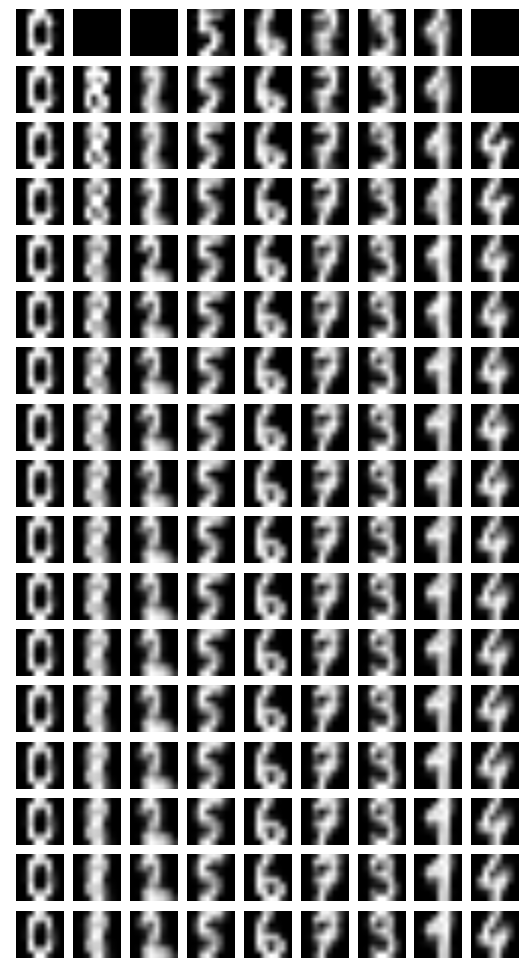

9


In [513]:
N_CLUSTERS = len(clusters[0])
NN = len(clusters)
edge=8
plt.figure(figsize=(N_CLUSTERS, NN))
for i in range(NN):
    for j in range(N_CLUSTERS):
        img = np.reshape(clusters[i], (N_CLUSTERS, edge, edge))
        sub = plt.subplot(NN, N_CLUSTERS, i * N_CLUSTERS + j + 1)
        sub.imshow(img[j,:,:,], cmap=plt.cm.gray)
        #, interpolation='nearest'
        sub.axis("off")
plt.show()
print N_CLUSTERS

In [395]:
dpmix.add_sample(X[11:100])
dpmix.var_inference(num_start=5,display=False, max_iter=200)
clasters = dpmix.show_clusters()

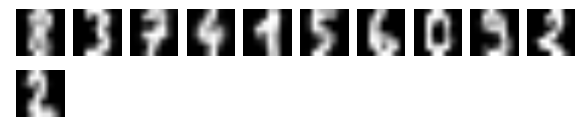

11


In [396]:
N_CLUSTERS = len(clasters)
edge=8
img = np.reshape(clasters, (N_CLUSTERS, edge, edge))
plt.figure(figsize=(10, 1 + N_CLUSTERS / 10))
for i in range(N_CLUSTERS):
    sub = plt.subplot(1 + N_CLUSTERS / 10, 10, i + 1)
    sub.imshow(img[i,:,:,], cmap=plt.cm.gray)
    #, interpolation='nearest'
    sub.axis("off")
plt.show()
print N_CLUSTERS

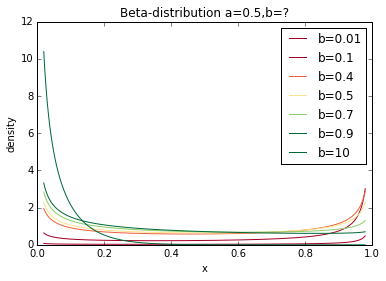

In [308]:
cm = plt.get_cmap("RdYlGn")
x = np.linspace(0.02, 0.98, 1000)
for b in [0.01, 0.1, 0.4, 0.5, 0.7, 0.9,10]:
    a=0.5
    plt.plot(x, beta.pdf(x, a,b), c=cm(math.log(b*3)), label='b='+str(b))
plt.ylabel('density')
#plt.yscale('log')
plt.xlabel('x')
plt.legend()
plt.title('Beta-distribution a=0.5,b=?')
plt.show()

In [358]:
z_train, z_test, y_train, y_test = train_test_split(z,y, test_size=0.3)
#KNeighborsClassifier
clf = OneVsOneClassifier(LinearSVC())
clf.fit(z_train,y_train)
y_pred = clf.predict(z_test)
accuracy_score(y_pred,y_test)

A = np.zeros((10,10))
for i in range(len(y_test)):
    A[y_test[i], y_pred[i]] +=1.

presision = A / A.sum(axis=0)
recall = A / A.sum(axis=1)
#print presision
#print recall
np.savetxt("presision.csv", presision)
np.savetxt("recall.csv", recall)

In [361]:
newrow = np.arange(10)
print np.vstack([A, newrow])

[[ 57.   0.   0.   0.   1.   1.   2.   0.   0.   1.]
 [  0.  37.  16.   0.   0.   0.   0.   0.   2.   0.]
 [  0.   0.  48.   0.   0.   0.   0.   0.   2.   5.]
 [  0.   0.   0.  39.   0.   1.   0.   2.   1.   8.]
 [  0.   0.   0.   0.  42.   0.   1.   3.   1.   0.]
 [  0.   0.   0.   0.   0.  56.   0.   0.   0.   2.]
 [  0.   0.   0.   0.   0.   0.  41.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.  54.   0.   0.]
 [  0.   1.   2.   0.   0.   1.   0.   2.  51.   3.]
 [  0.   2.   0.   2.   0.   2.   0.   4.   0.  46.]
 [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.]]


In [371]:
dpmix.show_clusters().sum(axis=1)

array([ 20.6666667 ,  32.        ,  32.        ,  32.        ,
        32.        ,  22.66666715])

In [375]:
dpmix.show_z().sum(axis=0) > 1e-4

array([ True, False, False, False, False,  True], dtype=bool)